# Tool Window Usage Analysis – Notebook (English)\nInteractive version of the main script.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (11, 5)
print('✅ Libraries ready')


✅ Libraries ready


In [37]:
import os, json

DATA = '../data/toolwindow_data.csv'  # change if needed
df = pd.read_csv(DATA)

# Normalize column names
df.columns = [c.lower().strip() for c in df.columns]

# If event column is called "event" instead of "event_id", rename it
if 'event' in df.columns and 'event_id' not in df.columns:
    df = df.rename(columns={'event': 'event_id'})

# Standardize important columns
for col in ['event_id', 'open_type', 'user_id']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

# Normalize event names
df['event_id'] = df['event_id'].replace({'opened': 'open', 'closed': 'close'})

# Convert timestamp to int64
df['timestamp'] = df['timestamp'].astype('int64')

df.head()


,timestamp,event_id,open_type,user_id
0,1752250204033,open,manual,1
1,1751836141616,close,nan,2
2,1752304475081,close,nan,3
3,1752498934494,open,auto,4
4,1752141991110,close,nan,5


In [38]:
def match(df, policy='close_previous'):
    episodes = []
    df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
    end_by_user = df.groupby('user_id')['timestamp'].max()

    for uid, g in df.groupby('user_id'):
        g = g.reset_index(drop=True)
        pending = None

        for _, r in g.iterrows():
            if r['event_id'] == 'open':
                if pending is not None:
                    if policy == 'close_previous':
                        dur = r['timestamp'] - pending['open_ts']
                        if dur >= 0:
                            episodes.append(dict(
                                user_id=uid,
                                open_timestamp=pending['open_ts'],
                                close_timestamp=r['timestamp'],
                                duration_ms=dur,
                                open_type=pending['open_type'],
                                censored=False
                            ))
                        pending = dict(open_ts=r['timestamp'], open_type=r.get('open_type'))
                    elif policy == 'drop_previous':
                        pending = dict(open_ts=r['timestamp'], open_type=r.get('open_type'))
                    else:  # keep_first
                        pass
                else:
                    pending = dict(open_ts=r['timestamp'], open_type=r.get('open_type'))

            elif r['event_id'] == 'close':
                if pending is not None:
                    dur = r['timestamp'] - pending['open_ts']
                    if dur >= 0:
                        episodes.append(dict(
                            user_id=uid,
                            open_timestamp=pending['open_ts'],
                            close_timestamp=r['timestamp'],
                            duration_ms=dur,
                            open_type=pending['open_type'],
                            censored=False
                        ))
                    pending = None

        # Handle last open without close (censored)
        if pending is not None:
            end = end_by_user.loc[uid]
            dur = end - pending['open_ts']
            if dur >= 0:
                episodes.append(dict(
                    user_id=uid,
                    open_timestamp=pending['open_ts'],
                    close_timestamp=None,
                    duration_ms=dur,
                    open_type=pending['open_type'],
                    censored=True
                ))

    epi = pd.DataFrame(episodes)
    if not epi.empty:
        epi['duration_seconds'] = epi['duration_ms'] / 1000
    return epi

# Call the function
episodes = match(df, 'close_previous')
episodes = episodes[episodes['open_type'].notna()]
episodes.head()


,user_id,open_timestamp,close_timestamp,duration_ms,open_type,censored,duration_seconds
0,1,1751826102123,1.751827e+12,643954,auto,False,643.954
1,1,1751841258635,1.751850e+12,8285974,manual,False,8285.974
2,1,1751985487772,1.751987e+12,1136113,manual,False,1136.113
3,1,1752250204033,1.752250e+12,748,manual,False,0.748
4,1,1752250205587,1.752257e+12,7227188,manual,False,7227.188


In [39]:
def iqr_clean(g, min_ms=100, k=3.0):
    # Remove durations shorter than the minimum threshold
    g = g[g['duration_ms'] >= min_ms]

    # Calculate IQR (Interquartile Range)
    Q1 = g['duration_seconds'].quantile(0.25)
    Q3 = g['duration_seconds'].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper bound for non-outlier episodes
    up = Q3 + k * IQR

    # Keep data within bounds
    return g[g['duration_seconds'] <= up]

# Apply IQR cleaning grouped by 'open_type' (future-proof)
try:
    # pandas >= 2.2
    clean = episodes.groupby('open_type', group_keys=False, include_groups=False).apply(iqr_clean)
except TypeError:
    # Older pandas versions: explicit concat (no warning)
    clean = pd.concat([iqr_clean(g) for _, g in episodes.groupby('open_type')], axis=0)


In [40]:
# Extract durations by open type
manual = clean.loc[clean['open_type'] == 'manual', 'duration_seconds']
auto = clean.loc[clean['open_type'] == 'auto', 'duration_seconds']

# Perform Mann-Whitney U test
U, p = stats.mannwhitneyu(manual, auto, alternative='two-sided')

# Display results
U, p


(np.float64(105866.5), np.float64(6.195212833264818e-90))

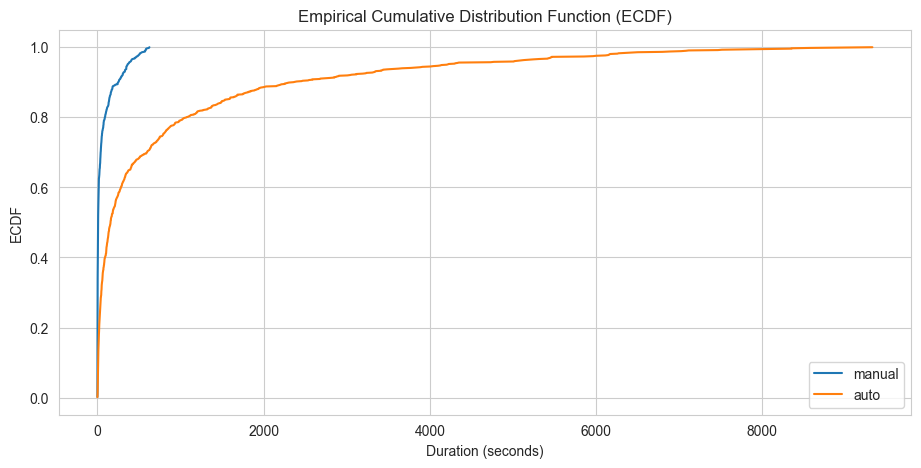

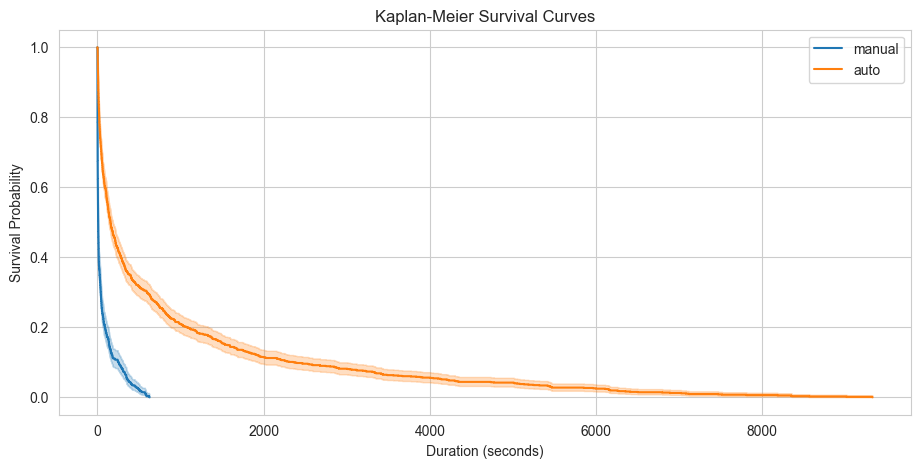

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# ===== ECDF Plot =====
plt.figure()
for lab in ['manual', 'auto']:
    s = np.sort(clean.loc[clean['open_type'] == lab, 'duration_seconds'])
    if s.size:
        y = np.arange(1, s.size + 1) / s.size
        plt.plot(s, y, label=lab)

plt.legend()
plt.xlabel('Duration (seconds)')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function (ECDF)')
plt.show()

# ===== Kaplan-Meier Survival Plot =====
km = KaplanMeierFitter()
plt.figure()

for lab in ['manual', 'auto']:
    g = clean[clean['open_type'] == lab]
    if not g.empty:
        km.fit(g['duration_seconds'], event_observed=(~g['censored']).astype(int), label=lab)
        km.plot()

plt.title('Kaplan-Meier Survival Curves')
plt.xlabel('Duration (seconds)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()
